# (25) ca awake -- organize func

**Motivation**: Run a reduced version of ```organize_func()``` from ```Register``` to save processed numpy arrays. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Which subs

In [2]:
files = sorted(filter(
    lambda s: 'awake' in s,
    os.listdir('/mnt/storage/hadi/Ca-fMRI/raw'),
))
subs = [
    int(re.findall(r'\d+', f.split('_')[0]).pop())
    for f in files
]
subs = [
    k for k, v in collections.Counter(subs).items()
    if k <= 10 and v >= 9
]
subs

[2, 6, 7, 9, 10]

In [3]:
mice = Mice(Config(
    nn=512,
    sub_ids=subs,
    ses_ids=[4],
    run_ids=range(1, 10 + 1),
))

## Organize func awake data

In [4]:
mice.setup_anat_data()
mice.setup_preproc_data(desc_ca2='awake')

from register.register import Register
register = Register(mice)

In [5]:
acc_bold = mice.node_lookup['bold']
acc_bold = list(acc_bold.values())
tsnr_masks = register.get_tsnr_masks(0.05, acc_bold)

In [6]:
mode = 'ca2'
desc = 'awake'

register.set_mode(mode)
accepted = mice.node_lookup[mode]
accepted = list(accepted.values())

logger = make_logger(
    name='organize_awake',
    path=register.mice.cfg.log_dir,
    verbose=register.verbose,
    module=__name__,
)
register.mice.setup_preproc_data(desc_ca2=desc)
register._organize_func(
    tsnr_masks=tsnr_masks[mode],
    accepted_regions=accepted,
    description=desc,
    logger=logger,
)

logger 'organize_awake_(2023_07_28).log' created at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-512*3/log

Organizing sub-SLC10_ses-4_run-9 (ca2 / awake): 100%|██████████| 50/50 [12:55<00:00, 15.51s/it] 


## Next ran Network:

```bash
time ./run_network.sh 512 3 ca2 rest
```

## Currently looping svinet:

```bash
time ./loop_svinet.sh 512 3 7 p15-sample 500 ca2 rest [0-9.,]+
```

Note: this ```[0-9.,]+``` means any band will be fit.

## Debug SVINET

This shows a previous results, and it is NOT awake.

In [2]:
mice = Mice(512)
props = {
    'mice': None,
    'num_k': 7,
    'perc': 'p15-sample',
    'mode': 'ca2',
    'task': 'rest',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'graph_type': 'real',
    'verbose': False,
}
props['mice'] = mice
bands = [None, 0.01, 0.5, (0.01, 0.5)]

In [3]:
mice.setup_preproc_data(desc={'ca2': 'preproc'})
b = bands[3]
mice.set_band(band={'ca2': b})

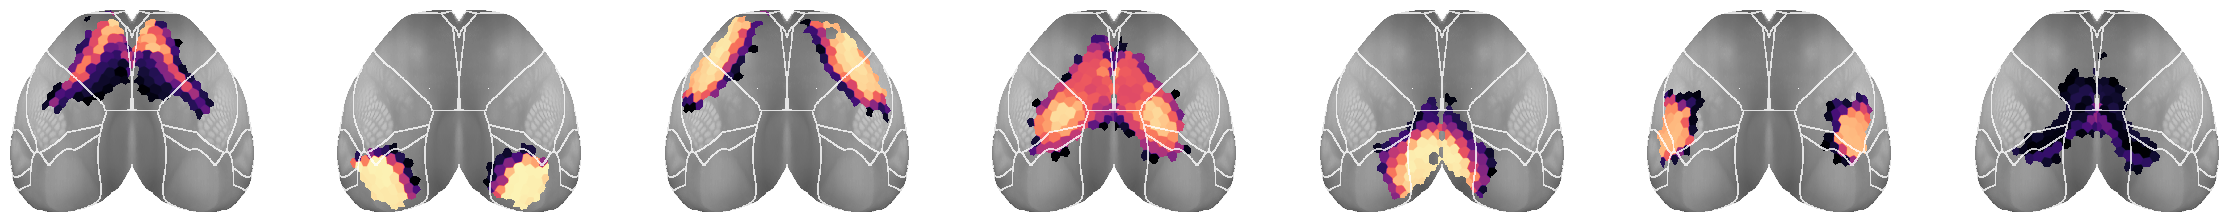

In [5]:
key = mice.get_key(9, 3, 5)
sv = SVINET(key=key, **props).fit_svinet()
sv.show(sv.pi, vmin=0.1, mask_thresh=0.1);

In [7]:
%%time

total = count_sv_fitted(mice.cfg.svinet_dir, 'p15-sample')
remaining = {
    b: np.round(100 * sum(e == 0 for e in d.values()) / len(d), 1)
    for b, d in total.items()
}

CPU times: user 14.8 s, sys: 8.82 s, total: 23.6 s
Wall time: 23.7 s


In [8]:
remaining

{'(0.0,5.0)': 50.9, '(0.01,0.5)': 46.4, '(0.01,5.0)': 46.4, '(0.5,5.0)': 50.9}

In [9]:
[b for b, d in total.items() if d[key] == 500]

['(0.01,0.5)', '(0.01,5.0)']

In [11]:
b = (0.01,5.0)
mice.set_band(band={'ca2': b})

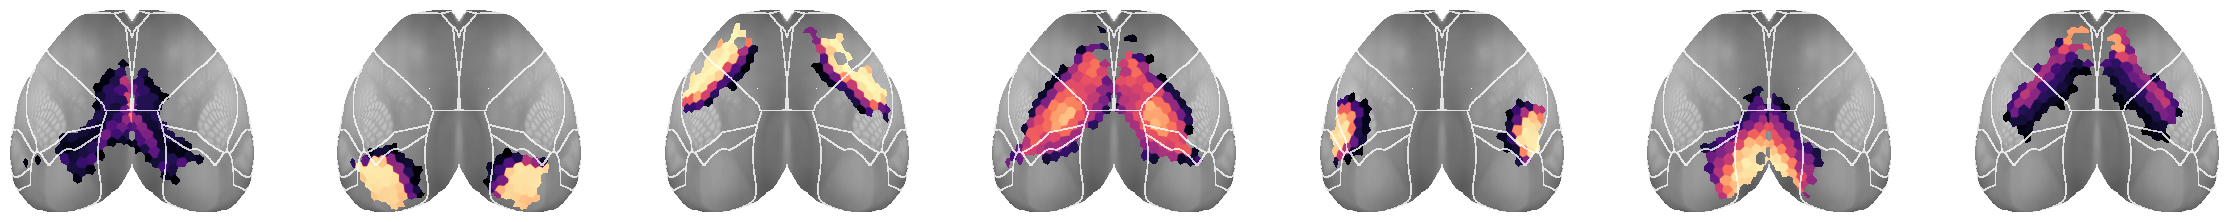

In [12]:
key = mice.get_key(9, 3, 5)
sv = SVINET(key=key, **props).fit_svinet()
sv.show(sv.pi, vmin=0.1, mask_thresh=0.1);

## Debug base

In [15]:
mice.set_band(band={'ca2': (0.01, 0.5)})
mice.setup_func_data(desc={'ca2': 'awake'})

In [16]:
bs = Base(
    mice=mice,
    mode='ca2',
    key='sub-SLC02_ses-4_run-1',
    prep_data=True,
)
bs.data.shape

(480, 5500)

In [17]:
bs.base_name

'n-512*3_bp(0.01,0.5)_ca2_rest_pearson_sub-SLC02_ses-4_run-1'

In [18]:
mice.band

{'bold': (0.0, 0.5), 'ca2': (0.01, 0.5)}

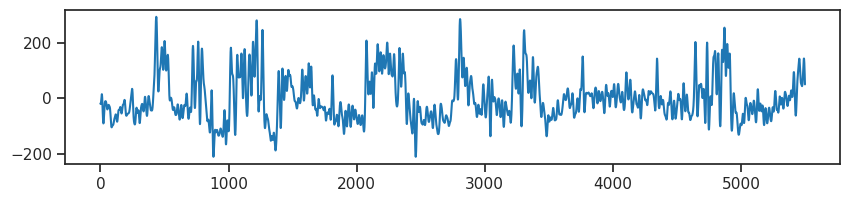

In [19]:
fig, ax = create_figure(1, 1, (10, 2))
plt.plot(np.nanmean(bs.data, 0));

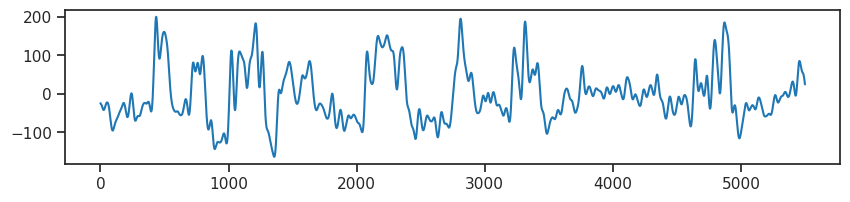

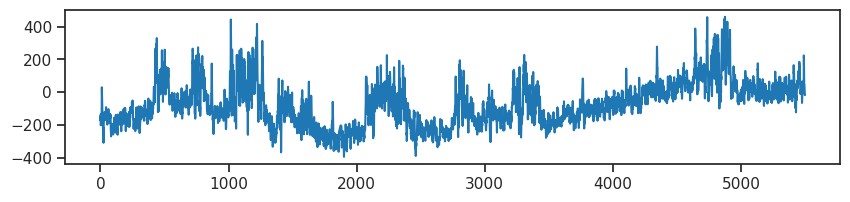

<Axes: ylabel='Count'>

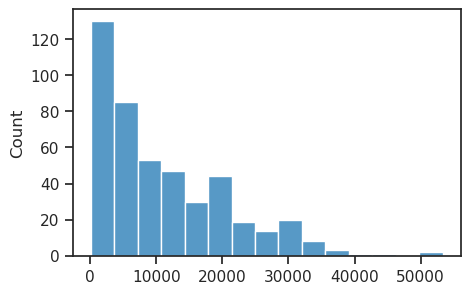

In [11]:
var = bn.nanvar(bs.data, axis=1)
sns.histplot(var)

In [15]:
np.where(var == np.nanmin(var))[0]

array([257])

[<matplotlib.lines.Line2D object at 0x7f59d4b67e50>]

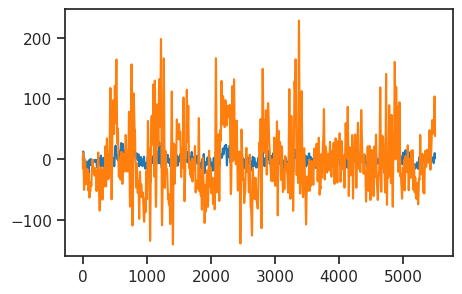

In [18]:
plt.plot(bs.data[257])
plt.plot(bs.data[41])

[<matplotlib.lines.Line2D object at 0x7f5865193d00>]

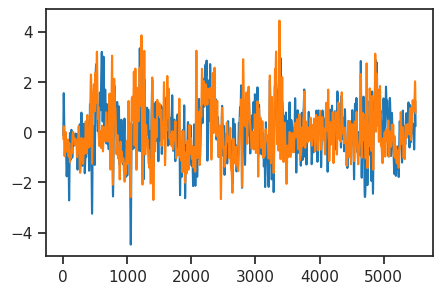

In [19]:
plt.plot(sp_stats.zscore(bs.data[257]))
plt.plot(sp_stats.zscore(bs.data[41]))

In [20]:
bs.base_name

'n-512*3_bp(0.01,0.5)_ca2_rest_pearson_sub-SLC02_ses-4_run-1'

In [58]:
sos = sp_sig.butter(N=3, Wn=(0.01, 0.5), fs=10, btype='band', output='sos')
x_slow = sp_sig.sosfiltfilt(sos=sos, x=data, axis=-1)

sos = sp_sig.butter(N=3, Wn=0.5, fs=10, btype='high', output='sos')
x_fast = sp_sig.sosfiltfilt(sos=sos, x=data, axis=-1)

sos = sp_sig.butter(N=3, Wn=0.01, fs=10, btype='high', output='sos')
x_hp = sp_sig.sosfiltfilt(sos=sos, x=data, axis=-1)

sos = sp_sig.butter(N=3, Wn=0.01, fs=10, btype='low', output='sos')
x_lp = sp_sig.sosfiltfilt(sos=sos, x=data, axis=-1)

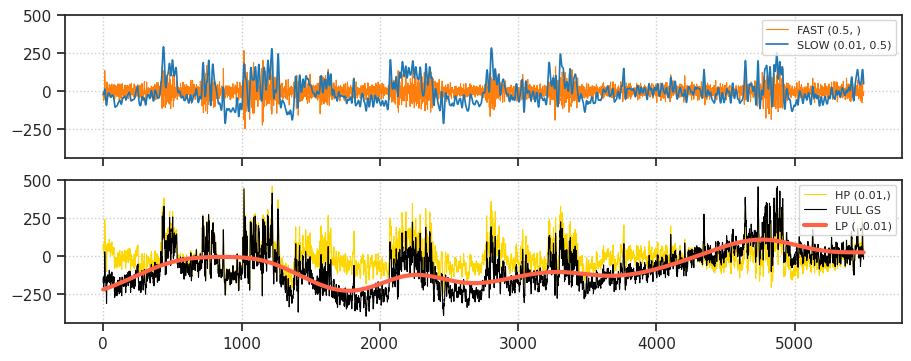

In [93]:
fig, axes = create_figure(2, 1, (9, 3.5), 'all', 'all', 'constrained')
axes[0].plot(np.nanmean(x_fast, 0), lw=0.8, color='C1', label='FAST (0.5, )')
axes[0].plot(np.nanmean(x_slow, 0), lw=1.2, color='C0', label='SLOW (0.01, 0.5)')

axes[1].plot(np.nanmean(x_hp, 0), lw=0.8, color='gold', label='HP (0.01,)')
axes[1].plot(np.nanmean(data, 0), lw=0.8, color='k', label='FULL GS')
axes[1].plot(np.nanmean(x_lp, 0), lw=3, color='tomato', label='LP ( ,0.01)')

for ax in axes.flat:
    ax.legend(fontsize=8, loc='upper right')
    # leg = ax.get_legend()
    # leg.set_bbox_to_anchor([1, 0.8])
    ax.grid()

plt.show()

In [94]:
df = pjoin(self.mice.cfg.base_dir, 'meta_info')
df = pd.read_pickle(pjoin(df, 'tmask_hp.df'))

In [95]:
df

,sub,ses,run,key,temporal_mask
0,1,1,1,sub-SLC01_ses-1_run-1,0
1,1,1,1,sub-SLC01_ses-1_run-1,0
2,1,1,1,sub-SLC01_ses-1_run-1,0
3,1,1,1,sub-SLC01_ses-1_run-1,0
4,1,1,1,sub-SLC01_ses-1_run-1,0
...,...,...,...,...,...
119995,10,3,7,sub-SLC10_ses-3_run-7,0
119996,10,3,7,sub-SLC10_ses-3_run-7,0
119997,10,3,7,sub-SLC10_ses-3_run-7,0
119998,10,3,7,sub-SLC10_ses-3_run-7,0


In [100]:
key = 'sub-SLC10_ses-3_run-7'

In [101]:
tmask = df.loc[
    df['key'] == key,
    'temporal_mask',
].values.astype(bool)

In [104]:
tmask.sum() / len(tmask)

0.86

In [109]:
tmask = np.repeat(tmask, fs)
tmask = tmask[ab]

In [110]:
assert data.shape[1] == len(tmask)

In [111]:
data.shape[1]

5500

In [106]:
tmask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        Tr

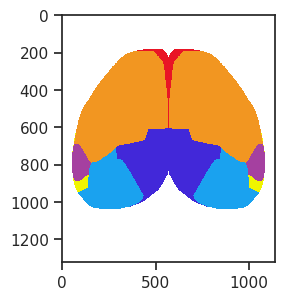

In [11]:
x2p = bs.affil['aff_top']
x2p = mwh(x2p == 0, x2p)
plt.imshow(x2p, cmap=bs.affil['cmap']);

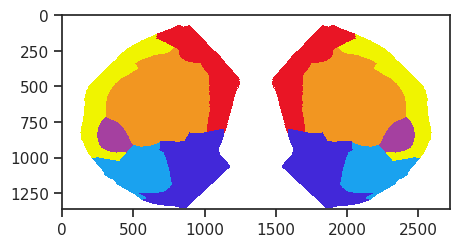

In [12]:
x2p = bs.affil['aff_flat']
x2p = mwh(x2p == 0, x2p)
plt.imshow(x2p, cmap=bs.affil['cmap']);

In [13]:
%%time

pi_fuse = bs.get_struct_fusion_pi()
pi_fuse.shape

CPU times: user 1.19 s, sys: 2.61 s, total: 3.8 s
Wall time: 4.05 s


(6, 2567)

In [14]:
a, b = bs.trim2d(bs.project_vec(np.ones(len(bs.n2id))))
a.shape, b.shape

((1, 857, 1034), (857, 1034))

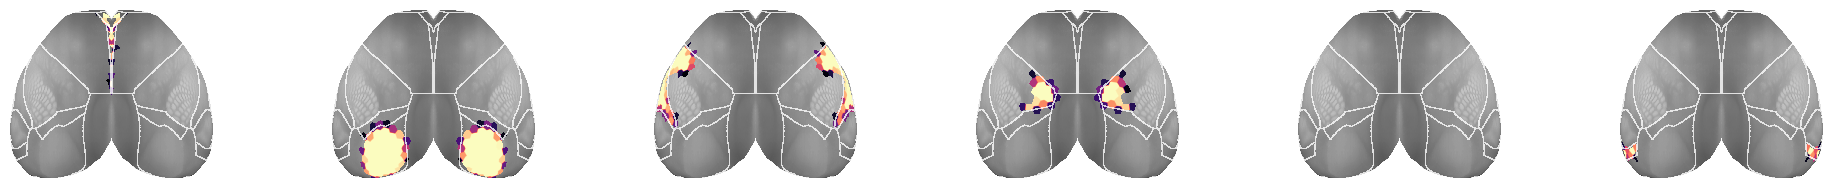

CPU times: user 4.31 s, sys: 3.62 s, total: 7.94 s
Wall time: 3.65 s


In [15]:
%%time

_ = bs.show(pi_fuse, proj='top', mask_thresh=0.1)

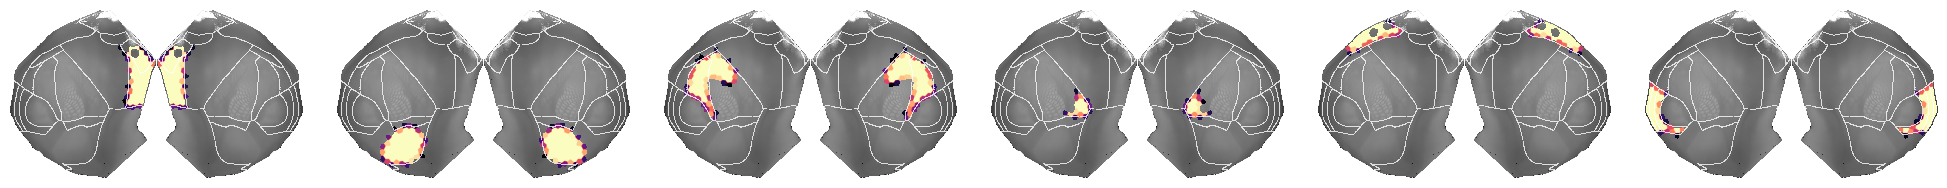

CPU times: user 8.12 s, sys: 1.24 s, total: 9.35 s
Wall time: 8.9 s


In [16]:
%%time

_ = bs.show(pi_fuse, proj='flat', mask_thresh=0.1)

In [17]:
list(bs.contours)

['top', 'flat']

<matplotlib.image.AxesImage object at 0x7f4c708ac5e0>

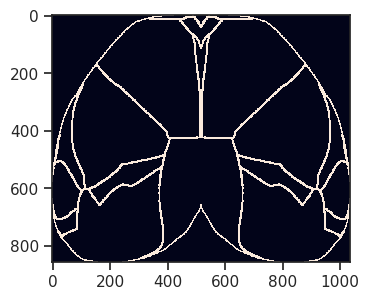

In [19]:
plt.imshow(bs.contours['top'])

<matplotlib.image.AxesImage object at 0x7f4c70814a00>

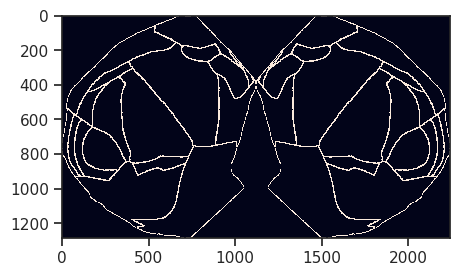

In [20]:
plt.imshow(bs.contours['flat'])

In [23]:
%%time

_ = bs.get_contour(proj='top', coarse=False)

CPU times: user 49 µs, sys: 0 ns, total: 49 µs
Wall time: 59.8 µs


In [26]:
%%time

_ = bs.get_contour(proj='flat', coarse=False)

CPU times: user 13 µs, sys: 7 µs, total: 20 µs
Wall time: 30 µs


In [43]:
self = bs
coarse = True

In [44]:
%%time


if self.affil is None:
    _ = self.node_affiliations()
obj = self.affil[f"obj_{proj}"].copy()

if coarse:
    subtree, _ = self.mice.al.get_subtree(315, 2, False)
    children = collections.defaultdict(list)
    nodes = [n.identifier for n in subtree.children(315)]
    nodes += [self.mice.al.get('SSp')['id']]
    for node in nodes:
        for child in subtree.children(node):
            children[node].append(child.identifier)

    for node, child_list in children.items():
        obj[np.isin(obj, child_list)] = node

CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 218 ms


In [45]:
%%time

get_contour(obj, 0.125, 0.3)

CPU times: user 4.08 s, sys: 678 ms, total: 4.76 s
Wall time: 4.76 s


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

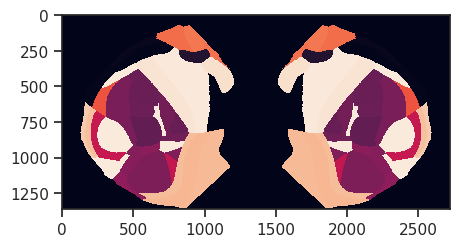

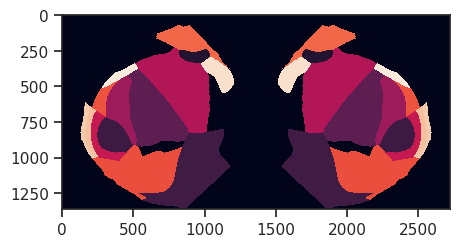

In [35]:
proj = 'flat'
obj = self.affil[f"obj_{proj}"].copy()
plt.imshow(obj, vmin=100, vmax=1000)
plt.show()



plt.imshow(obj, vmin=100, vmax=1000)
plt.show()